# <span style="color:red">DEEP LEARNING - Assignment </span>


Financial Engineering - Deep Learning

**Due date :** 20/03/2024

## <span style="color:green">PRELIMINARY STEP</span>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import random

# <span style="color:green">QUESTION 1</span>

## Preamble

In [2]:
def performance_metrics_of_regression(labels: np.ndarray,
                                      predictions: np.ndarray) -> tuple:
    """
    Compute standard performance metrics for regression: mse and Rsquared
    """
    mse = ((predictions - labels) ** 2).mean()
    r2 = 1 - mse / (labels ** 2).mean()
    print(f'r2 = {"%.2f" % r2}, mse = {"%.2f" % mse}')

    return mse, r2

def scatter_plot(x_: np.ndarray,
                 y_: np.ndarray,
                 name_x: str,
                 name_y: str,
                 ax=None):
    """
    scatter plot
    """
    data = pd.DataFrame(np.concatenate([x_, y_], axis=1),
                    columns=[name_x, name_y])
    if ax is None:
        sns.jointplot(data=data, x=name_x, y=name_y, kind="reg")
    else:
        sns.jointplot(data=data, x=name_x, y=name_y, kind="reg", ax=ax)

def normalize(data: np.ndarray,
              ready_normalization: dict = None,
              use_std: bool = False)->tuple:
  """

  """

  if ready_normalization is None:
      data_std = data.std(0)
      data_mean = data.mean(0)
      if use_std:
        data = (data - data_mean) / data_std
      else:
        data_max = np.max(data, axis=0)
        data_min = np.min(data, axis=0)
  else:
      data_std = ready_normalization['std']
      data_mean = ready_normalization['mean']
      if use_std:
        data = (data - data_mean) / data_std
      else:
        data_max = ready_normalization['max']
        data_min = ready_normalization['min']

  data = data - data_min
  data = data/(data_max - data_min)
  data = data - 0.5
  normalization = {'std': data_std,
                   'mean': data_mean,
                    'max': data_max,
                    'min': data_min}
  return data, normalization

def sharpe_ratio(x):
  return np.round(np.sqrt(12) * x.mean(0) / x.std(0), 2)


## Ridge regression function

In [3]:
def ridge_regr(signals: np.ndarray,
                  labels: np.ndarray,
                  future_signals: np.ndarray,
                  shrinkage_list: np.ndarray):
    """
    Regression is
    beta = (zI + S'S/t)^{-1}S'y/t = S' (zI+SS'/t)^{-1}y/t
    Inverting matrices is costly, so we use eigenvalue decomposition:
    (zI+A)^{-1} = U (zI+D)^{-1} U' where UDU' = A is eigenvalue decomposition,
    and we use the fact that D @ B = (diag(D) * B) for diagonal D, which saves a lot of compute cost
    :param signals: S
    :param labels: y
    :param future_signals: out of sample y
    :param shrinkage_list: list of ridge parameters
    :return:
    """
    t_ = signals.shape[0]
    p_ = signals.shape[1]
    if p_ < t_:
        # this is standard regression
        eigenvalues, eigenvectors = np.linalg.eigh(signals.T @ signals / t_)
        means = signals.T @ labels.reshape(-1, 1) / t_
        multiplied = eigenvectors.T @ means
        intermed = np.concatenate([(1 / (eigenvalues.reshape(-1, 1) + z)) * multiplied for z in shrinkage_list],
                                  axis=1)
        betas = eigenvectors @ intermed
    else:
        # this is the weird over-parametrized regime
        eigenvalues, eigenvectors = np.linalg.eigh(signals @ signals.T / t_)
        means = labels.reshape(-1, 1) / t_
        multiplied = eigenvectors.T @ means # this is \mu

        # now we build [(z_1+\delta)^{-1}, \cdots, (z_K+\delta)^{-1}] * \mu
        intermed = np.concatenate([(1 / (eigenvalues.reshape(-1, 1) + z)) * multiplied for z in shrinkage_list],
                                  axis=1)

        tmp = eigenvectors.T @ signals # U.T @ S
        betas = tmp.T @ intermed # (S.T @ U) @ [(z_1+\delta)^{-1}, \cdots, (z_K+\delta)^{-1}] * \mu
    predictions = future_signals @ betas
    return betas, predictions

## Data

In [4]:
goyal_welch_data = pd.read_csv('GoyalWelchPredictorData2022Monthly.csv', index_col=0)
goyal_welch_data.index = pd.to_datetime(goyal_welch_data.index, format='%Y%m')

fred_data = pd.read_csv('FRED_MD.csv', index_col=0).iloc[1:, :]
fred_data.index = pd.to_datetime(fred_data.index)

for column in goyal_welch_data.columns:
    goyal_welch_data[column] = [float(str(x).replace(',', '')) for x in goyal_welch_data[column]]

In [5]:
goyal_welch_data

,Index,D12,E12,b/m,tbl,AAA,BAA,lty,ntis,Rfree,infl,ltr,corpr,svar,csp,CRSP_SPvw,CRSP_SPvwx
yyyymm,,,,,,,,,,,,,,,,,
1871-01-01,4.44,0.2600,0.4000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1871-02-01,4.50,0.2600,0.4000,NaN,NaN,NaN,NaN,NaN,NaN,0.004967,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1871-03-01,4.61,0.2600,0.4000,NaN,NaN,NaN,NaN,NaN,NaN,0.004525,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1871-04-01,4.74,0.2600,0.4000,NaN,NaN,NaN,NaN,NaN,NaN,0.004252,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1871-05-01,4.86,0.2600,0.4000,NaN,NaN,NaN,NaN,NaN,NaN,0.004643,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-01,3955.00,64.8854,188.8067,0.227429,0.0263,0.0407,0.0515,0.0290,-0.009732,0.001900,-0.000354,-0.0421,-0.0293,0.003349,NaN,-0.040305,-0.042052
2022-09-01,3585.62,65.3183,187.0800,0.249478,0.0313,0.0459,0.0569,0.0352,-0.011292,0.001900,0.002151,-0.0769,-0.0526,0.004934,NaN,-0.091495,-0.092876
2022-10-01,3871.98,65.8531,182.3033,0.218935,0.0372,0.0510,0.0626,0.0398,-0.015252,0.002300,0.004056,-0.0139,-0.0103,0.006504,NaN,0.080248,0.079196


In [6]:
fred_data

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
sasdate,,,,,,,,,,,,,,,,,,,,,
1959-01-01,2583.560,2426.0,15.188,2.766768e+05,18235.77392,21.9665,23.3891,22.2688,31.7011,19.0149,...,18.294,10.152,2.13,2.45,2.04,NaN,6476.00,12298.00,84.2043,NaN
1959-02-01,2593.596,2434.8,15.346,2.787140e+05,18369.56308,22.3966,23.7048,22.4617,31.9337,19.1147,...,18.302,10.167,2.14,2.46,2.05,NaN,6476.00,12298.00,83.5280,NaN
1959-03-01,2610.396,2452.7,15.491,2.777753e+05,18523.05762,22.7193,23.8483,22.5719,31.9337,19.4890,...,18.289,10.185,2.15,2.45,2.07,NaN,6508.00,12349.00,81.6405,NaN
1959-04-01,2627.446,2470.0,15.435,2.833627e+05,18534.46600,23.2032,24.1927,22.9026,32.4374,19.6138,...,18.300,10.221,2.16,2.47,2.08,NaN,6620.00,12484.00,81.8099,NaN
1959-05-01,2642.720,2486.4,15.622,2.853072e+05,18679.66354,23.5528,24.3936,23.1231,32.5925,20.0130,...,18.280,10.238,2.17,2.48,2.08,95.3,6753.00,12646.00,80.7315,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-01,19082.740,15654.8,115.693,1.488903e+06,690518.00000,102.2924,100.5411,100.8521,101.3834,105.4454,...,118.369,122.797,29.52,34.04,26.40,64.2,492904.98,902738.96,5188.5907,14.0327
2023-07-01,19087.005,15685.9,116.386,1.499236e+06,694415.00000,103.2895,101.4622,102.0236,102.6790,108.8802,...,118.349,123.343,29.63,34.22,26.49,71.5,496830.25,907013.82,5166.2590,13.8333
2023-08-01,19094.368,15708.9,116.453,1.504807e+06,699882.00000,103.3170,101.4927,102.0126,102.5700,107.1656,...,119.995,123.552,29.74,34.41,26.54,69.4,501471.16,911782.00,5114.3583,15.7822


# Merged data

In [7]:
# Merge the datasets on their index (date)
merged_data = goyal_welch_data.merge(fred_data, left_index=True, right_index=True, how='inner')

# Display the first few rows of the merged dataset to ensure the merge was successful
merged_data.head(), merged_data.shape

(            Index     D12     E12       b/m     tbl   AAA_x   BAA_x     lty  \
 1959-01-01  55.42  1.7567  2.9633  0.502896  0.0282  0.0412  0.0487  0.0408   
 1959-02-01  55.41  1.7633  3.0367  0.494946  0.0270  0.0414  0.0489  0.0402   
 1959-03-01  55.44  1.7700  3.1100  0.516860  0.0280  0.0413  0.0485  0.0403   
 1959-04-01  57.59  1.7767  3.2067  0.498597  0.0295  0.0423  0.0486  0.0414   
 1959-05-01  58.68  1.7833  3.3033  0.483077  0.0284  0.0437  0.0496  0.0417   
 
                 ntis   Rfree  ...  DNDGRG3M086SBEA  DSERRG3M086SBEA  \
 1959-01-01  0.027736  0.0021  ...           18.294           10.152   
 1959-02-01  0.027899  0.0019  ...           18.302           10.167   
 1959-03-01  0.024984  0.0022  ...           18.289           10.185   
 1959-04-01  0.024361  0.0020  ...           18.300           10.221   
 1959-05-01  0.025887  0.0022  ...           18.280           10.238   
 
             CES0600000008  CES2000000008  CES3000000008  UMCSENTx  \
 1959-01-01   

## Data processing

In [8]:
merged_data['returns'] = ((merged_data.Index)/ merged_data.Index.shift(1) - 1).fillna(0)
merged_data['returns'].describe()

count    768.000000
mean       0.006460
std        0.042865
min       -0.217630
25%       -0.017624
50%        0.009340
75%        0.034435
max        0.163047
Name: returns, dtype: float64

<Axes: >

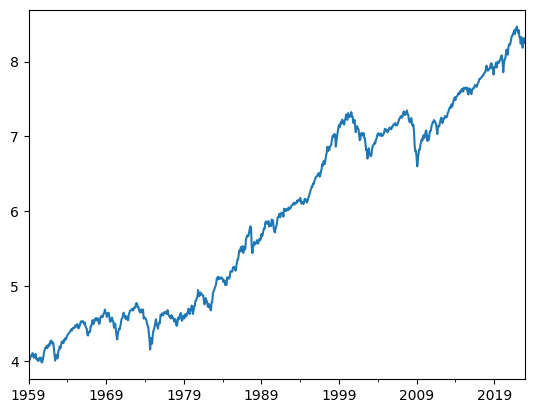

In [9]:
np.log(merged_data['Index']).plot()

Excess returns are defined as $R_{t+1}-r_{f,t}$ (in excess of the risk-free rate).   
Then, we know that, with portfolio weight $\pi_t,$ the wealth evolves as:
$$
W_{t+1}\ =\ W_t(r_{f,t} + \pi_t (R_{t+1}-r_{f,t}))
$$

Text(0.5, 1.0, 'leverage = 2')

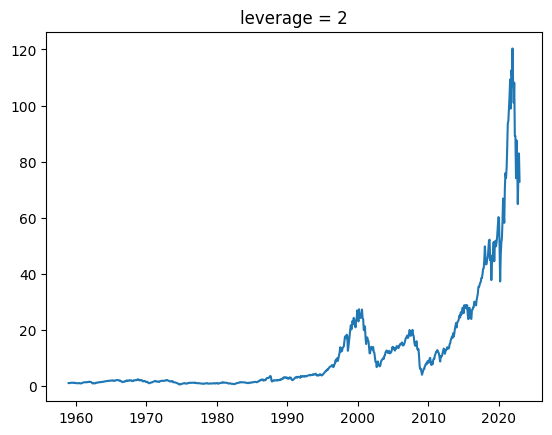

In [10]:
merged_data['excess_returns'] = merged_data.returns - merged_data.Rfree
leverage = 2
strategy_returns = 1 + merged_data.Rfree + leverage * merged_data.excess_returns
plt.plot(np.cumprod(strategy_returns))
plt.title(f'leverage = {leverage}')

In [11]:
merged_data.corr()

,Index,D12,E12,b/m,tbl,AAA_x,BAA_x,lty,ntis,Rfree,...,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx,returns,excess_returns
Index,1.000000,0.970546,0.960600,-0.620760,-0.574500,-0.568855,-0.538275,-0.626934,-0.432750,-0.569768,...,0.888344,0.892032,0.877188,-0.034006,0.912050,0.836119,0.973840,0.068140,0.028533,0.062977
D12,0.970546,1.000000,0.952432,-0.582980,-0.576798,-0.543822,-0.501761,-0.606212,-0.526518,-0.571468,...,0.922434,0.927418,0.910450,-0.088505,0.927407,0.857517,0.981166,0.073708,0.012921,0.047529
E12,0.960600,0.952432,1.000000,-0.565623,-0.533130,-0.529786,-0.502515,-0.581626,-0.456829,-0.530634,...,0.891340,0.895317,0.880347,-0.082556,0.924961,0.852310,0.962082,-0.008622,0.009400,0.041546
b/m,-0.620760,-0.582980,-0.565623,1.000000,0.681269,0.632229,0.641006,0.656438,0.267423,0.665575,...,-0.649930,-0.629704,-0.658583,-0.389688,-0.641491,-0.679420,-0.590865,-0.035048,-0.050992,-0.091157
tbl,-0.574500,-0.576798,-0.533130,0.681269,1.000000,0.878498,0.849176,0.893437,0.191371,0.986850,...,-0.546927,-0.535542,-0.540428,-0.042547,-0.640498,-0.665418,-0.623066,0.000908,-0.038825,-0.098524
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DTCTHFNM,0.836119,0.857517,0.852310,-0.679420,-0.665418,-0.551628,-0.503796,-0.612422,-0.539166,-0.651884,...,0.940686,0.933577,0.939691,-0.116050,0.971082,1.000000,0.889734,0.129716,-0.006207,0.033355
INVEST,0.973840,0.981166,0.962082,-0.590865,-0.623066,-0.571177,-0.527784,-0.631193,-0.483146,-0.619713,...,0.928465,0.932051,0.917358,-0.166271,0.955081,0.889734,1.000000,0.089388,0.010522,0.048066
VIXCLSx,0.068140,0.073708,-0.008622,-0.035048,0.000908,0.117363,0.176294,0.056083,-0.171134,0.008784,...,0.161275,0.165426,0.163934,-0.259434,0.104408,0.129716,0.089388,1.000000,-0.196921,-0.196628
returns,0.028533,0.012921,0.009400,-0.050992,-0.038825,-0.015197,-0.008049,-0.019211,-0.035858,-0.035008,...,0.021138,0.020333,0.022369,0.039556,0.001976,-0.006207,0.010522,-0.196921,1.000000,0.998161


In [12]:
cleaned_data = merged_data.loc['1975':].drop(columns=['csp']).fillna(0)
cleaned_data

,Index,D12,E12,b/m,tbl,AAA_x,BAA_x,lty,ntis,Rfree,...,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx,returns,excess_returns
1975-01-01,76.98,3.6233,8.7433,0.980830,0.0626,0.0883,0.1081,0.0796,0.008510,0.0058,...,4.95,6.59,4.54,0.0,10465.00,35598.00,172.2165,26.7976,0.122812,0.117012
1975-02-01,81.59,3.6467,8.5967,0.933902,0.0550,0.0862,0.1065,0.0788,0.011652,0.0043,...,4.98,6.58,4.58,57.6,10533.00,35442.00,172.0668,22.9871,0.059886,0.055586
1975-03-01,83.36,3.6700,8.4500,0.972466,0.0549,0.0867,0.1048,0.0824,0.020467,0.0041,...,5.03,6.74,4.63,0.0,10412.00,34997.00,177.2118,24.0618,0.021694,0.017594
1975-04-01,87.30,3.6833,8.2867,0.909489,0.0561,0.0895,0.1058,0.0852,0.022496,0.0044,...,5.04,6.73,4.63,0.0,10332.00,34824.00,182.0769,22.6474,0.047265,0.042865
1975-05-01,91.15,3.6967,8.1233,0.897524,0.0523,0.0890,0.1069,0.0836,0.022954,0.0044,...,5.06,6.74,4.65,72.8,10374.00,34790.00,183.8810,21.0543,0.044101,0.039701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-01,3955.00,64.8854,188.8067,0.227429,0.0263,0.0407,0.0515,0.0290,-0.009732,0.0019,...,28.14,32.55,25.15,58.2,448726.84,894209.68,5751.9093,22.3008,-0.042440,-0.044340
2022-09-01,3585.62,65.3183,187.0800,0.249478,0.0313,0.0459,0.0569,0.0352,-0.011292,0.0019,...,28.27,32.74,25.26,58.6,452094.91,890597.65,5670.6098,27.0915,-0.093396,-0.095296
2022-10-01,3871.98,65.8531,182.3033,0.218935,0.0372,0.0510,0.0626,0.0398,-0.015252,0.0023,...,28.41,32.88,25.38,59.9,455441.43,889337.93,5565.7427,29.9215,0.079863,0.077563
2022-11-01,4080.11,66.3880,177.5267,0.207182,0.0415,0.0490,0.0607,0.0389,-0.017011,0.0029,...,28.58,33.00,25.60,56.7,459789.97,887778.13,5515.0485,23.0367,0.053753,0.050853


## Signals generation

In [13]:
data_for_signals = cleaned_data[cleaned_data.columns].shift(1).fillna(0) # shifting of signals happens here !
labels = cleaned_data.excess_returns.values.reshape(-1, 1)
data_for_signals['infl'] = data_for_signals['infl'].shift(1).fillna(0)
signals = data_for_signals.values
data_for_signals.shape, data_for_signals.columns

((576, 145),
 Index(['Index', 'D12', 'E12', 'b/m', 'tbl', 'AAA_x', 'BAA_x', 'lty', 'ntis',
        'Rfree',
        ...
        'CES0600000008', 'CES2000000008', 'CES3000000008', 'UMCSENTx',
        'DTCOLNVHFNM', 'DTCTHFNM', 'INVEST', 'VIXCLSx', 'returns',
        'excess_returns'],
       dtype='object', length=145))

In [14]:
normalize_raw_data = True
cheat_and_use_future_data = False  # set to True if you want to have
#our fun experiment to show how even know a bit about the future can drastically imprpve performance

shrinkage_list = [0.00000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]

split = int(signals.shape[0] / 2)
train_labels = labels[:split]
test_labels = labels[split:]

if normalize_raw_data:
    signals[:split, :], normalization_based_on_train = normalize(signals[:split], use_std=False)
    # this is our fun experiment to show how even know a bit about the future can drastically imprpve performance
    if cheat_and_use_future_data:
      signals[split:, :] = normalize(signals[split:, :])[0]
    else:
      signals[split:, :] = normalize(signals[split:, :],
                                     ready_normalization=normalization_based_on_train)[0]

beta_estimate_using_train_sample, oos_predictions = ridge_regr(signals=signals[:split, :],
                                                                labels=train_labels,
                                                                future_signals=signals[split:, :],
                                                                shrinkage_list=shrinkage_list)

oos_predictions = pd.DataFrame(oos_predictions, index=cleaned_data.index[split:], columns = shrinkage_list)
oos_predictions

,1.000000e-08,1.000000e-05,1.000000e-04,1.000000e-03,1.000000e-02,1.000000e-01,1.000000e+00,1.000000e+01,1.000000e+02,1.000000e+03
1999-01-01,0.046618,0.034234,0.016737,0.002190,0.000396,0.007706,0.008461,0.003708,0.000573,0.000061
1999-02-01,-0.018910,-0.019440,-0.025896,-0.015228,0.000623,0.008697,0.008592,0.003729,0.000575,0.000061
1999-03-01,-0.011065,-0.008128,-0.012933,-0.001455,0.004281,0.007415,0.008204,0.003664,0.000567,0.000060
1999-04-01,-0.040908,-0.030551,-0.035635,-0.021718,-0.004148,0.007135,0.008355,0.003705,0.000573,0.000061
1999-05-01,-0.041575,-0.027370,-0.040161,-0.029169,-0.008240,0.006548,0.008368,0.003723,0.000576,0.000061
...,...,...,...,...,...,...,...,...,...,...
2022-08-01,5.598586,-3.368697,-0.836963,-1.937632,-1.244935,-0.200269,0.019242,0.016392,0.002641,0.000281
2022-09-01,5.931038,-3.136639,-0.751092,-1.937280,-1.259753,-0.204487,0.018779,0.016374,0.002641,0.000281
2022-10-01,5.936246,-3.150150,-0.743057,-1.838215,-1.190922,-0.192922,0.018799,0.015983,0.002575,0.000274
2022-11-01,5.761239,-3.322517,-0.804264,-1.814811,-1.168820,-0.187024,0.019202,0.015880,0.002554,0.000272


In [15]:
pd.DataFrame(beta_estimate_using_train_sample, columns=shrinkage_list, index=data_for_signals.columns)

,1.000000e-08,1.000000e-05,1.000000e-04,1.000000e-03,1.000000e-02,1.000000e-01,1.000000e+00,1.000000e+01,1.000000e+02,1.000000e+03
Index,-0.755726,-0.500848,-0.163504,-0.040169,-0.011002,-0.001591,-0.000157,-0.000030,-0.000005,-5.562392e-07
D12,0.196420,-0.394625,-0.148562,-0.019329,-0.001697,-0.000004,0.000164,0.000067,0.000010,1.021023e-06
E12,-0.397450,-0.044847,0.024193,0.015729,0.010660,0.002426,0.000312,0.000056,0.000007,7.062517e-07
b/m,0.405143,0.235879,0.151686,0.064011,0.016020,0.001766,-0.000114,-0.000055,-0.000007,-7.639919e-07
tbl,0.278907,0.091245,-0.025235,-0.028966,-0.011979,-0.003224,-0.000720,-0.000117,-0.000014,-1.419924e-06
...,...,...,...,...,...,...,...,...,...,...
DTCTHFNM,-0.544294,-0.147645,-0.012604,0.012254,0.005215,0.001080,0.000229,0.000042,0.000005,4.525233e-07
INVEST,0.367595,0.567924,0.210243,0.034614,0.000129,-0.000540,0.000084,0.000047,0.000007,6.897800e-07
VIXCLSx,-0.023507,0.010990,0.033968,0.047872,0.023100,0.003108,0.000236,-0.000001,-0.000002,-2.273687e-07
returns,-1.029298,-0.058850,-0.008465,-0.013539,-0.007204,-0.000479,0.000132,0.000049,0.000008,8.006075e-07


In [16]:
market_timing_returns = oos_predictions * test_labels.reshape(-1, 1)
market_timing_returns # we have one timing return for each value of z

,1.000000e-08,1.000000e-05,1.000000e-04,1.000000e-03,1.000000e-02,1.000000e-01,1.000000e+00,1.000000e+01,1.000000e+02,1.000000e+03
1999-01-01,0.001749,0.001284,0.000628,0.000082,0.000015,0.000289,0.000317,0.000139,0.000021,0.000002
1999-02-01,0.000677,0.000696,0.000927,0.000545,-0.000022,-0.000311,-0.000307,-0.000133,-0.000021,-0.000002
1999-03-01,-0.000382,-0.000280,-0.000446,-0.000050,0.000148,0.000256,0.000283,0.000126,0.000020,0.000002
1999-04-01,-0.001401,-0.001046,-0.001220,-0.000744,-0.000142,0.000244,0.000286,0.000127,0.000020,0.000002
1999-05-01,0.001180,0.000776,0.001139,0.000828,0.000234,-0.000186,-0.000237,-0.000106,-0.000016,-0.000002
...,...,...,...,...,...,...,...,...,...,...
2022-08-01,-0.248242,0.149368,0.037111,0.085915,0.055201,0.008880,-0.000853,-0.000727,-0.000117,-0.000012
2022-09-01,-0.565202,0.298908,0.071576,0.184614,0.120049,0.019487,-0.001790,-0.001560,-0.000252,-0.000027
2022-10-01,0.460436,-0.244336,-0.057634,-0.142578,-0.092372,-0.014964,0.001458,0.001240,0.000200,0.000021
2022-11-01,0.292975,-0.168959,-0.040899,-0.092288,-0.059438,-0.009511,0.000976,0.000808,0.000130,0.000014


In [17]:
cleaned_data = pd.concat([cleaned_data, market_timing_returns], axis=1)
cleaned_data

,Index,D12,E12,b/m,tbl,AAA_x,BAA_x,lty,ntis,Rfree,...,0.0,0.00001,0.0001,0.001,0.01,0.1,1.0,10.0,100.0,1000.0
1975-01-01,76.98,3.6233,8.7433,0.980830,0.0626,0.0883,0.1081,0.0796,0.008510,0.0058,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1975-02-01,81.59,3.6467,8.5967,0.933902,0.0550,0.0862,0.1065,0.0788,0.011652,0.0043,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1975-03-01,83.36,3.6700,8.4500,0.972466,0.0549,0.0867,0.1048,0.0824,0.020467,0.0041,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1975-04-01,87.30,3.6833,8.2867,0.909489,0.0561,0.0895,0.1058,0.0852,0.022496,0.0044,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1975-05-01,91.15,3.6967,8.1233,0.897524,0.0523,0.0890,0.1069,0.0836,0.022954,0.0044,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-01,3955.00,64.8854,188.8067,0.227429,0.0263,0.0407,0.0515,0.0290,-0.009732,0.0019,...,-0.248242,0.149368,0.037111,0.085915,0.055201,0.008880,-0.000853,-0.000727,-0.000117,-0.000012
2022-09-01,3585.62,65.3183,187.0800,0.249478,0.0313,0.0459,0.0569,0.0352,-0.011292,0.0019,...,-0.565202,0.298908,0.071576,0.184614,0.120049,0.019487,-0.001790,-0.001560,-0.000252,-0.000027
2022-10-01,3871.98,65.8531,182.3033,0.218935,0.0372,0.0510,0.0626,0.0398,-0.015252,0.0023,...,0.460436,-0.244336,-0.057634,-0.142578,-0.092372,-0.014964,0.001458,0.001240,0.000200,0.000021
2022-11-01,4080.11,66.3880,177.5267,0.207182,0.0415,0.0490,0.0607,0.0389,-0.017011,0.0029,...,0.292975,-0.168959,-0.040899,-0.092288,-0.059438,-0.009511,0.000976,0.000808,0.000130,0.000014


In [18]:
tmp = cleaned_data[['excess_returns'] + shrinkage_list].iloc[split:]
tmp = tmp / tmp.std()
sr = sharpe_ratio(tmp)

Text(0.5, 1.0, 'SR=[ 0.28  0.44  0.26  0.18 -0.42 -0.45 -0.45  0.32  0.39  0.4   0.4 ]')

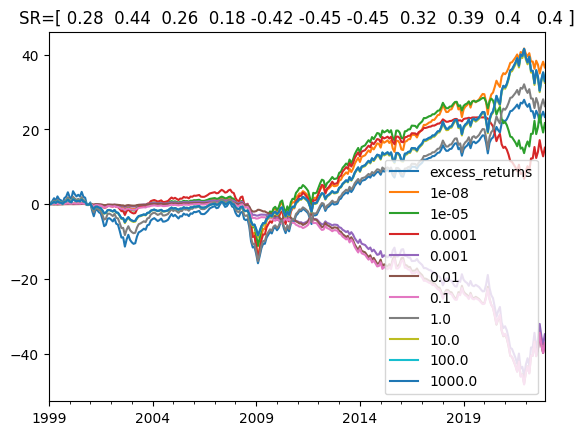

In [19]:
tmp.cumsum().plot()
plt.title(f'SR={sr.values.flatten()}')

# <span style="color:green">QUESTION 2.1</span>

### Set the seed

In [20]:
np.random.seed(42)

### ACTIVATION FUNCTIONS:

In [21]:
# We define activation functions
def relu(x):
    return np.maximum(0, x)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def tanh(x):
    return np.tanh(x)

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def leaky_relu(x, alpha=0.01):
    return np.where(x > 0, x, alpha * x)

def elu(x, alpha=1.0):
    return np.where(x > 0, x, alpha * (np.exp(x) - 1))

def gelu(x):
    return x * 0.5 * (1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * np.power(x, 3))))

def cos(x):
    return np.cos(x)

def sin(x):
    return np.sin(x)

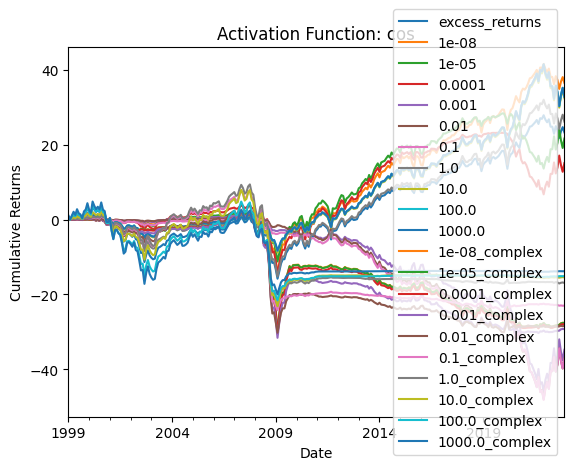

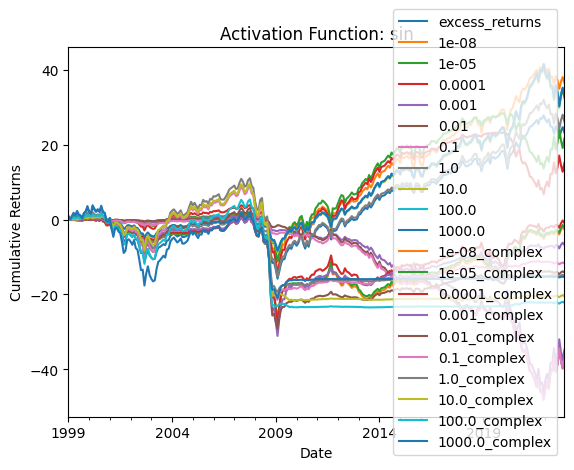

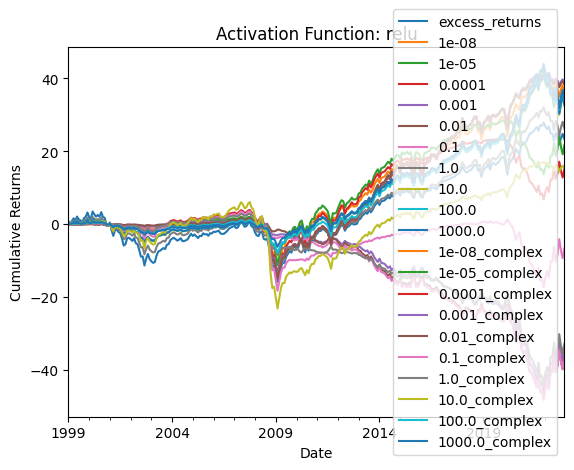

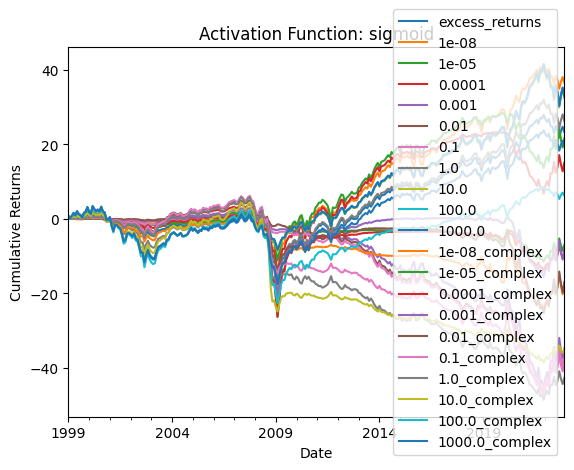

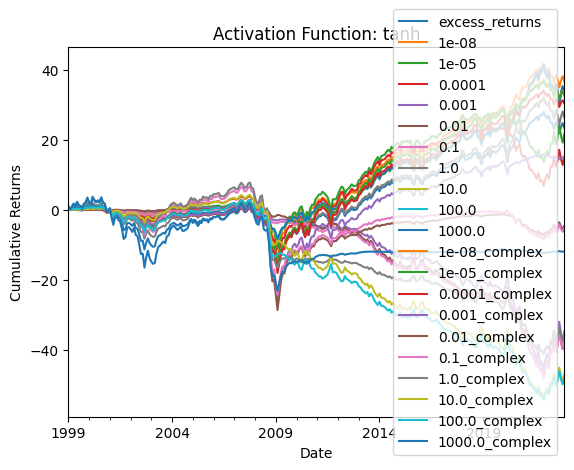

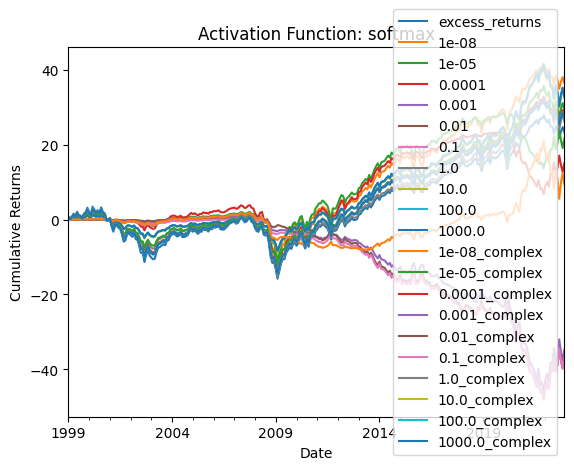

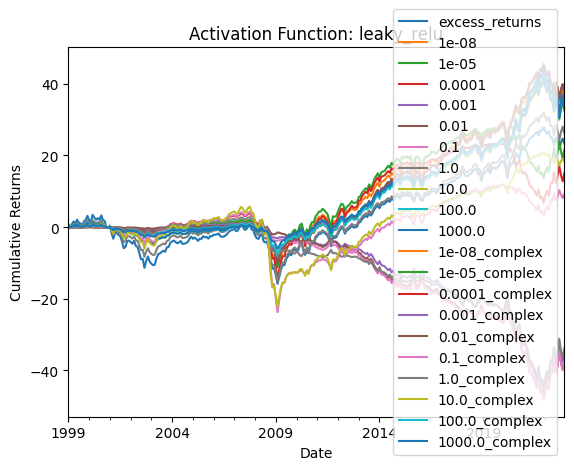

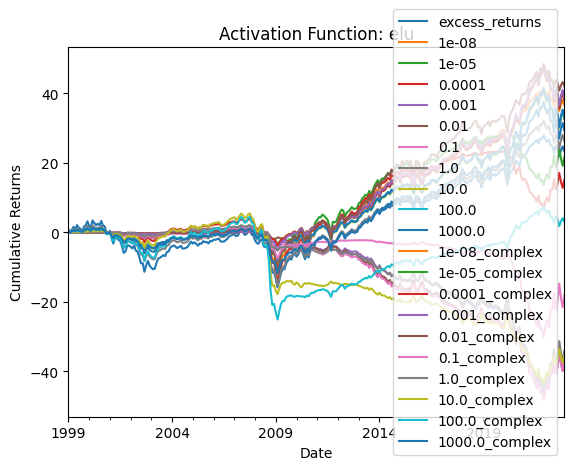

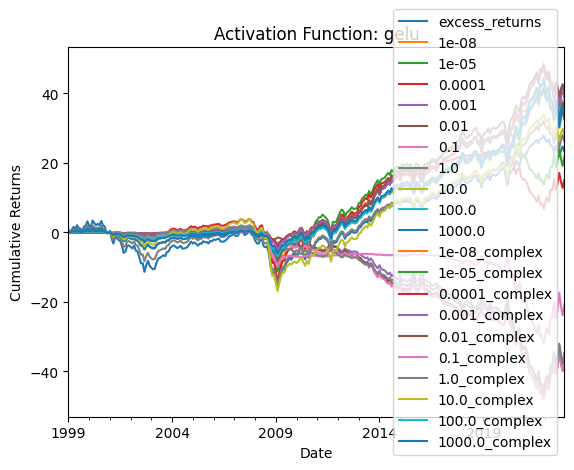

In [22]:
P = 50000
d = 145
scale = 1
split = int(signals.shape[0] / 2)

# Initialize list of activation functions
activation_functions = [cos, sin, relu, sigmoid, tanh, softmax, leaky_relu, elu, gelu]

# Loop over activation functions
for activation_func in activation_functions:
    # Generate random features using the chosen activation function
    omega = scale * np.sqrt(2) * np.random.randn(P, d) / np.sqrt(d)
    ins_activation = np.sqrt(2) * activation_func(signals @ omega.T)
    random_features = np.append(ins_activation, ins_activation, axis=1)

    # Train ridge regression model and make predictions
    beta_estimate_using_train_sample, oos_predictions = ridge_regr(signals=random_features[:split, :],
                                                                    labels=train_labels,
                                                                    future_signals=random_features[split:, :],
                                                                    shrinkage_list=shrinkage_list)

    # Convert predictions to DataFrame
    oos_predictions = pd.DataFrame(oos_predictions, index=cleaned_data.index[split:], columns=shrinkage_list)

    # Calculate market timing returns
    market_timing_returns_complex = oos_predictions * test_labels
    market_timing_returns_complex.columns = [f'{x}_complex' for x in market_timing_returns_complex.columns]

    # Concatenate market timing returns to cleaned data
    cleaned_data_with_rf = pd.concat([cleaned_data, market_timing_returns_complex], axis=1)

    # Select relevant columns, adjust for the period after the split, and standardize
    tmp = cleaned_data_with_rf[['excess_returns'] + shrinkage_list + list(market_timing_returns_complex.columns)].iloc[split:, :]
    tmp = tmp / tmp.std()

    # Calculate cumulative sum for plotting
    cumulative_returns = tmp.cumsum()

    # Plot cumulative returns
    ax = cumulative_returns.plot()
    ax.legend(loc='right')
    plt.title(f'Activation Function: {activation_func.__name__}')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.show()

### SCALE - GAMMA

Scale: 0.01, Cumulative Sum: 104.92669666325537
Scale: 0.5357894736842106, Cumulative Sum: 18.328882365645626
Scale: 1.0615789473684212, Cumulative Sum: -81.09892015844915
Scale: 1.5873684210526318, Cumulative Sum: -107.2166404696108
Scale: 2.113157894736842, Cumulative Sum: -87.37203178251461
Scale: 2.6389473684210527, Cumulative Sum: -10.617994060199848
Scale: 3.1647368421052633, Cumulative Sum: -5.528462477646373
Scale: 3.690526315789474, Cumulative Sum: -9.63551937290975
Scale: 4.2163157894736845, Cumulative Sum: 12.290429305743258
Scale: 4.742105263157895, Cumulative Sum: -4.2991616767973815
Scale: 5.267894736842106, Cumulative Sum: 76.47345103413963
Scale: 5.793684210526316, Cumulative Sum: -35.97438238854313
Scale: 6.319473684210527, Cumulative Sum: 170.3198713224472
Scale: 6.845263157894737, Cumulative Sum: -49.222035050861464
Scale: 7.371052631578948, Cumulative Sum: -49.708379655774536
Scale: 7.8968421052631586, Cumulative Sum: 105.07403535850081
Scale: 8.42263157894737, Cumu

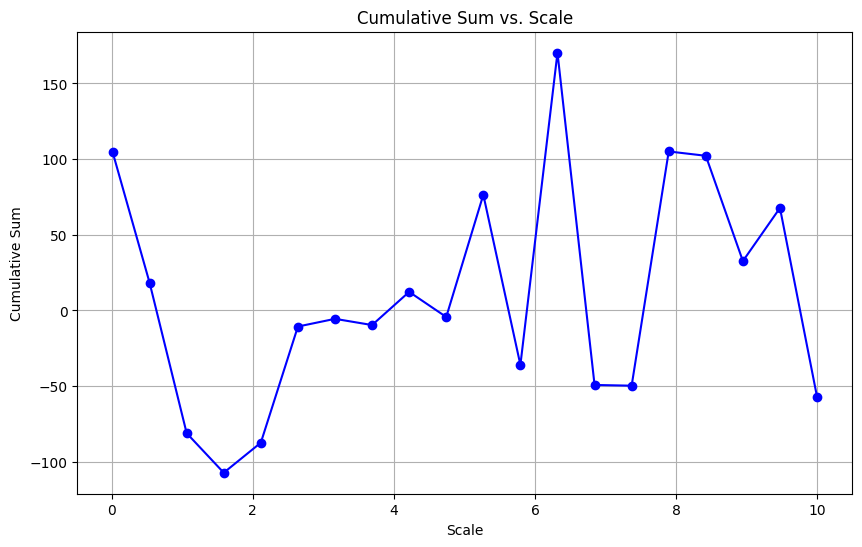

In [23]:
def generate_random_features(scale, signals, P=50000, d=145):
    omega = scale * np.sqrt(2) * np.random.randn(P, d) / np.sqrt(d)
    ins_sin = np.sqrt(2) * np.sin(signals @ omega.T)
    ins_cos = np.sqrt(2) * np.cos(signals @ omega.T)
    return np.append(ins_sin, ins_cos, axis=1)

def calculate_cumulative_sum(scale):
    random_features = generate_random_features(scale, signals)
    split = int(signals.shape[0] / 2)
    labels = cleaned_data.excess_returns.values.reshape(-1, 1)
    train_labels = labels[:split]
    test_labels = labels[split:]
    beta_estimate_using_train_sample, oos_predictions = ridge_regr(signals=random_features[:split, :],
                                                                    labels=train_labels,
                                                                    future_signals=random_features[split:, :],
                                                                    shrinkage_list=shrinkage_list)
    oos_predictions = pd.DataFrame(oos_predictions, index=cleaned_data.index[split:], columns = shrinkage_list)
    market_timing_returns_complex = oos_predictions * test_labels
    market_timing_returns_complex.columns = [f'{x}_complex' for x in market_timing_returns_complex.columns]
    cleaned_data_with_rf = pd.concat([cleaned_data, market_timing_returns_complex], axis=1)
    tmp = cleaned_data_with_rf[['excess_returns'] + shrinkage_list + list(market_timing_returns_complex.columns)].iloc[split:, :]
    tmp = tmp / tmp.std()
    cumulative_returns = tmp.cumsum().iloc[-1, :]
    total_cumulative_return = cumulative_returns.sum()
    return total_cumulative_return

# Initialize variables for plotting
scale_values = np.linspace(0.01, 10, 20)
cumulative_sums = []
best_scale = None
best_cumulative_sum = -np.inf

for scale in scale_values:
    current_cumulative_sum = calculate_cumulative_sum(scale)
    cumulative_sums.append(current_cumulative_sum)  # Append current cumulative sum to the list
    print(f"Scale: {scale}, Cumulative Sum: {current_cumulative_sum}")
    if current_cumulative_sum > best_cumulative_sum:
        best_cumulative_sum = current_cumulative_sum
        best_scale = scale

print(f"Best scale: {best_scale} with a cumulative sum of: {best_cumulative_sum}")

# Plotting the cumulative sums against the scale values
plt.figure(figsize=(10, 6))
plt.plot(scale_values, cumulative_sums, marker='o', linestyle='-', color='b')
plt.title('Cumulative Sum vs. Scale')
plt.xlabel('Scale')
plt.ylabel('Cumulative Sum')
plt.grid(True)
plt.show()

The plot of scale shows:  
- **Volatility in Performance:** The cumulative sum exhibits significant volatility across different scale values. For instance, there are points where the cumulative sum reaches notably high values, suggesting optimal scales that maximize the model's predictions. Conversely, there are also dips into negative values, signifying scales that lead to poor model performance. **The plot exhibits an U shape.**
- **Optimal Scale Identification:** The plot suggests that there are specific scale values where the model achieves notably better performance. These optimal points are characterized by local maxima in the cumulative sum. **Such a optimization is only local as we need to take into account the Shrinkage and the activation function**

### Shrinkage

Shrinkage: 1e-05, Cumulative Sum: -1.748892937657898
Shrinkage: 0.0001, Cumulative Sum: -0.5047655359958516
Shrinkage: 0.001, Cumulative Sum: -0.7739952020009467
Shrinkage: 0.01, Cumulative Sum: -0.3659411622774774
Shrinkage: 0.1, Cumulative Sum: -0.2021332681425034
Shrinkage: 1, Cumulative Sum: -0.09604885207934928
Shrinkage: 10, Cumulative Sum: -0.046184545616379045
Shrinkage: 100, Cumulative Sum: -0.017055276793709075
Shrinkage: 1000, Cumulative Sum: -0.005710190354152622
Best shrinkage: 1000 with a cumulative sum of: -0.005710190354152622


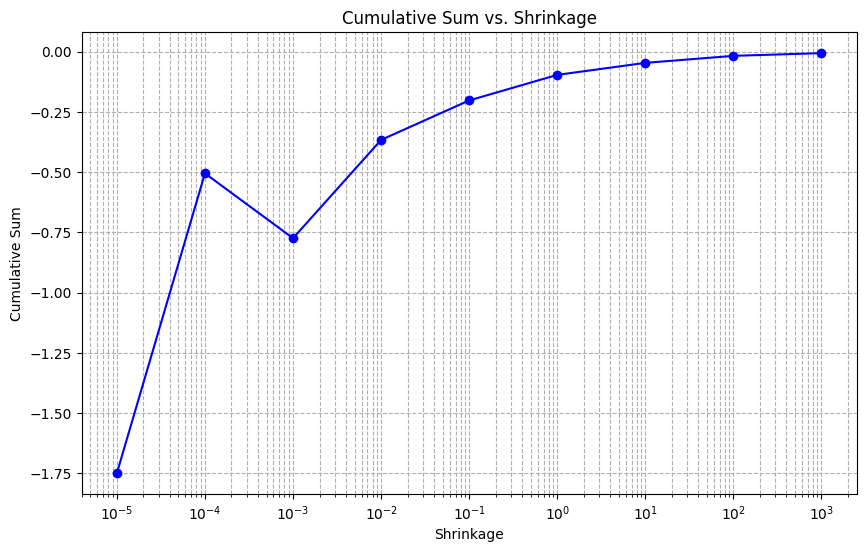

In [25]:
# Setting the seed for reproducibility
np.random.seed(42)

def generate_random_features(scale, signals, P=50000, d=145):
    omega = scale * np.sqrt(2) * np.random.randn(P, d) / np.sqrt(d)
    ins_sin = np.sqrt(2) * np.sin(signals @ omega.T)
    ins_cos = np.sqrt(2) * np.cos(signals @ omega.T)
    return np.append(ins_sin, ins_cos, axis=1)

def calculate_cumulative_sum(shrinkage):
    # Fixed scale for this example
    scale = 1
    random_features = generate_random_features(scale, signals)
    split = int(signals.shape[0] / 2)
    labels = cleaned_data.excess_returns.values.reshape(-1, 1)
    train_labels = labels[:split]
    test_labels = labels[split:]
    beta_estimate_using_train_sample, oos_predictions = ridge_regr(signals=random_features[:split, :],
                                                                    labels=train_labels,
                                                                    future_signals=random_features[split:, :],
                                                                    shrinkage_list=[shrinkage])
    oos_predictions = pd.DataFrame(oos_predictions, index=cleaned_data.index[split:], columns = [shrinkage])
    market_timing_returns = oos_predictions * test_labels
    total_cumulative_return = market_timing_returns.sum()
    return total_cumulative_return

# Shrinkage values to test
shrinkage_list = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
cumulative_sums = []
best_shrinkage = None
best_cumulative_sum = -np.inf

for shrinkage in shrinkage_list:
    current_cumulative_sum = calculate_cumulative_sum(shrinkage).iloc[0]
    cumulative_sums.append(current_cumulative_sum)  # Append current cumulative sum to the list
    print(f"Shrinkage: {shrinkage}, Cumulative Sum: {current_cumulative_sum}")
    if current_cumulative_sum > best_cumulative_sum:
        best_cumulative_sum = current_cumulative_sum
        best_shrinkage = shrinkage

print(f"Best shrinkage: {best_shrinkage} with a cumulative sum of: {best_cumulative_sum}")

# Plotting the cumulative sums against the shrinkage values
plt.figure(figsize=(10, 6))
plt.semilogx(shrinkage_list, cumulative_sums, marker='o', linestyle='-', color='b')
plt.title('Cumulative Sum vs. Shrinkage')
plt.xlabel('Shrinkage')
plt.ylabel('Cumulative Sum')
plt.grid(True, which="both", ls="--")
plt.show()


This plots shows:  
- **Increasing Trend:** As shrinkage increases, there's a general upward trend in cumulative sum, though it starts to plateau at higher values of shrinkage. This could indicate that adding more regularization (higher shrinkage) initially improves the model's performance by reducing overfitting, but beyond a certain point, additional shrinkage does not yield significant benefits.

- **Shrinkage Sensitivity:** The plot shows a sensitivity to the shrinkage parameter, especially at lower values. A notable dip occurs early in the shrinkage spectrum, suggesting that too little regularization may detrimentally affect the model's predictive ability. This emphasizes the importance of fine-tuning the shrinkage parameter in ridge regression to balance bias and variance.

### Optimization

In [24]:
import time

# Start the timer
start_time = time.time()

# List of activation functions to iterate over
activation_functions = [cos, sin, relu, sigmoid, tanh, softmax, leaky_relu, elu, gelu]

# Shrinkage list to iterate over
shrinkage_list = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]

# Scale values to iterate over
scale_values = np.linspace(0.01, 10, 20)

# Function to generate random features
def generate_random_features(scale, signals, activation_function, P=50000, d=145):
    omega = scale * np.sqrt(2) * np.random.randn(P, d) / np.sqrt(d)
    activated_signals = np.sqrt(2) * activation_function(signals @ omega.T)
    return np.concatenate([activated_signals, activated_signals], axis=1)

best_performance = -np.inf
best_params = {'scale': None, 'activation': None, 'shrinkage': None}

for activation_function in activation_functions:
    for scale in scale_values:
        # Generate random features for the current scale and activation function
        random_features = generate_random_features(scale, signals, activation_function)
        split = int(signals.shape[0] / 2)
        train_features = random_features[:split, :]
        test_features = random_features[split:, :]
        
        for shrinkage in shrinkage_list:
            # Train ridge regression model and make predictions
            beta_estimate, oos_predictions = ridge_regr(
                signals=train_features,
                labels=train_labels,
                future_signals=test_features,
                shrinkage_list=[shrinkage]
            )
            
            # Calculate market timing returns
            market_timing_returns = oos_predictions[:, 0] * test_labels  # Assuming oos_predictions has the correct shape
            cumulative_return = np.sum(market_timing_returns)
            
            # Update best parameters if current combination performs better
            if cumulative_return > best_performance:
                best_performance = cumulative_return
                best_params['scale'] = scale
                best_params['activation'] = activation_function.__name__
                best_params['shrinkage'] = shrinkage

# Stop the timer
end_time = time.time()

# Print the best parameters and their performance
print(f"Best Parameters: Scale = {best_params['scale']}, Activation = {best_params['activation']}, Shrinkage = {best_params['shrinkage']}")
print(f"Best Cumulative Return: {best_performance}")

# Calculate and print the execution time
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

Best Parameters: Scale = 0.5357894736842106, Activation = gelu, Shrinkage = 1e-05
Best Cumulative Return: 9576.27906616346
Execution time: 886.1636307239532 seconds


# <span style="color:green">QUESTION 2.2</span>

## TRAINING OF THE NN

In [26]:
def get_train_and_test_data(signals, labels, cleaned_data, normalize_raw_data=True, cheat_and_use_future_data=False):
    split = int(signals.shape[0] / 2)
    train_labels = labels[:split]
    test_labels = labels[split:]
    test_dates = cleaned_data.excess_returns.index[split:]

    if normalize_raw_data:
        signals[:split, :], normalization = normalize(signals[:split])
        if cheat_and_use_future_data:
            signals[split:, :] = normalize(signals[split:, :])[0]
        else:
            signals[split:, :], normalization = normalize(signals[split:, :], ready_normalization=normalization)
    train_data = signals[:split, :]
    test_data = signals[split:, :]
    return train_data, test_data, train_labels, test_labels, test_dates

In [27]:
X_train, X_test, y_train, y_test, test_dates = get_train_and_test_data(signals, labels, cleaned_data)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create TensorDatasets and DataLoaders for training and test sets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Here we are going to investigate the role of different activation function: sigmoid, ReLu, Identity, Tanh.
Here the ReLU activation function seems the more relevant and gives the best results.

In [28]:
class FlexibleMLP(nn.Module):
    def __init__(self, layers):
        super(FlexibleMLP, self).__init__()
        self.layers = nn.ModuleList()
        self.activations = nn.ModuleList()

        for i in range(len(layers) - 1):
            layer = nn.Linear(layers[i], layers[i+1])

            # LeCun initialization
            nn.init.normal_(layer.weight, mean=0.0, std=np.sqrt(1 / layers[i]))
            nn.init.normal_(layer.bias, mean=0.0, std=np.sqrt(1 / layers[i]))

            self.layers.append(layer)
            # Add ReLU activation after each layer except the last
            if i < len(layers) - 2:
                self.activations.append(nn.ReLU())
            else:
                # Placeholder for the last layer's activation
                self.activations.append(nn.Identity())

    def forward(self, x, return_last_hidden=False):
        last_hidden = None

        for layer, activation in zip(self.layers[:-1], self.activations[:-1]):
            x = activation(layer(x))
            last_hidden = x  # Update last_hidden at each hidden layer

        # Apply the last layer without ReLU (or Identity for the placeholder)
        x = self.layers[-1](x)

        if return_last_hidden:
            return x, last_hidden
        return x

    def set_seed(seed_value=42):
      """Set seed for reproducibility."""
      np.random.seed(seed_value)  # Set NumPy seed
      torch.manual_seed(seed_value)  # Set PyTorch seed
      random.seed(seed_value)  # Set Python random seed

      # If you are using CUDA:
      if torch.cuda.is_available():
          torch.cuda.manual_seed(seed_value)
          torch.cuda.manual_seed_all(seed_value)  # For multi-GPU
          torch.backends.cudnn.deterministic = True
          torch.backends.cudnn.benchmark = False

In [29]:
def train_model(num_epochs: int,
                train_loader: DataLoader,
                criterion,
                optimizer,
                model):
  # Training loop
  for epoch in range(num_epochs):
      for inputs, targets in train_loader:
          # Forward pass
          outputs = model(inputs)
          loss = criterion(outputs, targets)

          # Backward and optimize
          optimizer.zero_grad() # kill old gradients
          loss.backward() # compute new gradients
          optimizer.step() # perform the step of gradient descent

      if (epoch+1) % 20 == 0:
          print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

In [30]:
# Initialize the deep neural network model
num_seeds = 20

FlexibleMLP.set_seed(42)
width = 150
model_architecture = [X_train.shape[1], width, 1]
models = [FlexibleMLP(model_architecture) for seed in range(num_seeds)]


# Proceed with the rest of the setup (loss, optimizer) and training loop as before
# Loss and optimizer
for seed in range(num_seeds):

  FlexibleMLP.set_seed(seed)
  criterion = nn.MSELoss()
  optimizer = optim.Adam(models[seed].parameters(), lr=0.01, weight_decay=0.1)  # Using Adam optimizer for better performance with deep networks

  train_model(num_epochs=20,
              train_loader=train_loader,
              criterion=criterion,
              optimizer=optimizer,
              model=models[seed])

Epoch [20/20], Loss: 0.0025
Epoch [20/20], Loss: 0.0026
Epoch [20/20], Loss: 0.0025
Epoch [20/20], Loss: 0.0025
Epoch [20/20], Loss: 0.0025
Epoch [20/20], Loss: 0.0024
Epoch [20/20], Loss: 0.0025
Epoch [20/20], Loss: 0.0025
Epoch [20/20], Loss: 0.0025
Epoch [20/20], Loss: 0.0025
Epoch [20/20], Loss: 0.0025
Epoch [20/20], Loss: 0.0025
Epoch [20/20], Loss: 0.0025
Epoch [20/20], Loss: 0.0025
Epoch [20/20], Loss: 0.0025
Epoch [20/20], Loss: 0.0024
Epoch [20/20], Loss: 0.0025
Epoch [20/20], Loss: 0.0025
Epoch [20/20], Loss: 0.0025
Epoch [20/20], Loss: 0.0026


## EVALUATION OF THE NN

In [31]:
# Ensure the model is in evaluation mode
# Function to get predictions
def get_predictions(loader, model):
    model.eval()
    targets = []
    predictions = []

    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            targets.extend(labels.numpy())
            predictions.extend(outputs.numpy())

    return np.array(targets).flatten(), np.array(predictions).flatten()

# Get predictions for both training and test sets
train_sample = [get_predictions(train_loader, models[seed]) for seed in range(num_seeds)]
test_sample = [get_predictions(test_loader, models[seed]) for seed in range(num_seeds)]
train_targets = train_sample[0][0]

#
train_predictions = np.concatenate([train_sample[seed][1].reshape(-1, 1) for seed in range(num_seeds)], axis=1).mean(1)

test_targets = test_sample[0][0]
all_test_predictions = np.concatenate([test_sample[seed][1].reshape(-1, 1) for seed in range(num_seeds)], axis=1)
test_predictions = all_test_predictions.mean(1)

In [32]:
# Calculate MSE for both training and test sets
train_mse = np.mean((train_targets - train_predictions) ** 2) / np.mean(train_targets ** 2)
test_mse = np.mean((test_targets - test_predictions) ** 2) / np.mean(test_targets ** 2)
mse_df = pd.DataFrame({'MSE': [train_mse, test_mse]}, index=['Train', 'Test'])
mse_df

,MSE
Train,0.981549
Test,1.007531


In [33]:
def validate_model(validation_loader, model):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0

    with torch.no_grad():  # No gradients needed
        for data, target in validation_loader:
            output = model(data)
            loss = criterion(output, target)  # Assuming 'criterion' is your loss function for MSE
            total_loss += loss.item()

    avg_loss = total_loss / len(validation_loader.dataset)
    return avg_loss  # Return average loss over the validation dataset

Here, we study the role of learning rate, batch size, weight decay and number of epochs. The goal is to print the best parameters

### LEARNING RATE, BATCH SIZES, WEIGHT DECAYS, NUMBER OF EPOCHS, DEPTH

### Optimization algorithm

In [59]:
import time

# Start timing
start_time = time.time()

# Define parameter grids
learning_rates = [0.1, 0.01, 0.001, 0.0001]
batch_sizes = [16, 32, 64, 128]
weight_decays = [0.1, 0.01, 0.001, 0.0001]
num_epochs_options = [5, 10, 20, 50]
width_values = [50, 100, 150]

best_validation_performance = float('inf')
best_params = {}

validation_loader = test_loader  # Using test_loader for validation purposes

for width in width_values:
    for lr in learning_rates:
        for weight_decay in weight_decays:
            for num_epochs in num_epochs_options:
                for index, model in enumerate(models):
                    # Set seed for reproducibility
                    FlexibleMLP.set_seed(42)

                    # Define model architecture
                    model_architecture = [X_train.shape[1], width, 1]
                    model = FlexibleMLP(model_architecture)

                    # Define optimizer and criterion
                    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
                    criterion = nn.MSELoss()  # Use Mean Squared Error Loss

                    # Train model
                    train_model(num_epochs=num_epochs,
                                train_loader=train_loader,
                                criterion=criterion,
                                optimizer=optimizer,
                                model=model)

                    # Validate model
                    validation_performance = validate_model(validation_loader, model)

                    # Update best parameters if validation performance is better
                    if validation_performance < best_validation_performance:
                        best_validation_performance = validation_performance
                        best_params = {
                            'width': width,
                            'lr': lr,
                            'weight_decay': weight_decay,
                            'num_epochs': num_epochs,
                            'model_index': index
                        }

# Print best parameters
print(f"Best Params: {best_params}")

# End timing
end_time = time.time()
total_duration = end_time - start_time
print(f"Total Duration: {total_duration} seconds")

Epoch [20/20], Loss: 0.0032
Epoch [20/20], Loss: 0.0032
Epoch [20/20], Loss: 0.0032
Epoch [20/20], Loss: 0.0032
Epoch [20/20], Loss: 0.0032
Epoch [20/20], Loss: 0.0032
Epoch [20/20], Loss: 0.0032
Epoch [20/20], Loss: 0.0032
Epoch [20/20], Loss: 0.0032
Epoch [20/20], Loss: 0.0032
Epoch [20/20], Loss: 0.0032
Epoch [20/20], Loss: 0.0032
Epoch [20/20], Loss: 0.0032
Epoch [20/20], Loss: 0.0032
Epoch [20/20], Loss: 0.0032
Epoch [20/20], Loss: 0.0032
Epoch [20/20], Loss: 0.0032
Epoch [20/20], Loss: 0.0032
Epoch [20/20], Loss: 0.0032
Epoch [20/20], Loss: 0.0032
Epoch [20/50], Loss: 0.0032
Epoch [40/50], Loss: 0.0353
Epoch [20/50], Loss: 0.0032
Epoch [40/50], Loss: 0.0353
Epoch [20/50], Loss: 0.0032
Epoch [40/50], Loss: 0.0353
Epoch [20/50], Loss: 0.0032
Epoch [40/50], Loss: 0.0353
Epoch [20/50], Loss: 0.0032
Epoch [40/50], Loss: 0.0353
Epoch [20/50], Loss: 0.0032
Epoch [40/50], Loss: 0.0353
Epoch [20/50], Loss: 0.0032
Epoch [40/50], Loss: 0.0353
Epoch [20/50], Loss: 0.0032
Epoch [40/50], Loss:

According to the previous code, the code takes 1516 seconds to run.
The optimal learning rate is 0.01,the optimal width is 150, the optimal weight decay is 0.1, the optimal number of epoch is 20. We use these parameters to run again the code and have better results.

In [34]:
def validate_model(validation_loader, model):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0

    with torch.no_grad():  # No gradients needed
        for data, target in validation_loader:
            output = model(data)
            loss = criterion(output, target)  # Assuming 'criterion' is your loss function for MSE
            total_loss += loss.item()

    avg_loss = total_loss / len(validation_loader.dataset)
    return avg_loss  # Return average loss over the validation dataset

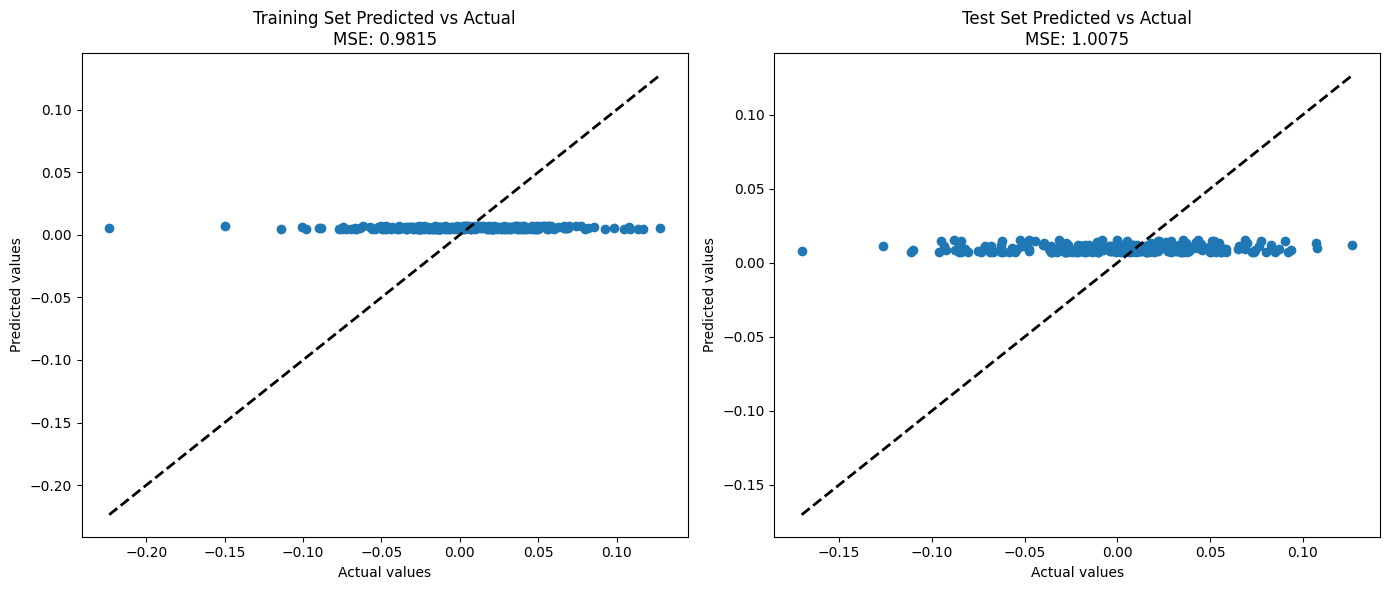

In [35]:
# Ensure the model is in evaluation mode
# Function to get predictions
def get_predictions(loader, model):
    model.eval()
    targets = []
    predictions = []

    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            targets.extend(labels.numpy())
            predictions.extend(outputs.numpy())

    return np.array(targets).flatten(), np.array(predictions).flatten()

# Get predictions for both training and test sets
train_sample = [get_predictions(train_loader, models[seed]) for seed in range(num_seeds)]
test_sample = [get_predictions(test_loader, models[seed]) for seed in range(num_seeds)]
train_targets = train_sample[0][0]

#
train_predictions = np.concatenate([train_sample[seed][1].reshape(-1, 1) for seed in range(num_seeds)], axis=1).mean(1)

test_targets = test_sample[0][0]
all_test_predictions = np.concatenate([test_sample[seed][1].reshape(-1, 1) for seed in range(num_seeds)], axis=1)
test_predictions = all_test_predictions.mean(1)

# Calculate MSE for both training and test sets
train_mse = np.mean((train_targets - train_predictions) ** 2) / np.mean(train_targets ** 2)
test_mse = np.mean((test_targets - test_predictions) ** 2) / np.mean(test_targets ** 2)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Training set subplot
axs[0].scatter(train_targets, train_predictions)
axs[0].plot([train_targets.min(), train_targets.max()], [train_targets.min(), train_targets.max()], 'k--', lw=2)  # Diagonal line
axs[0].set_xlabel('Actual values')
axs[0].set_ylabel('Predicted values')
axs[0].set_title(f'Training Set Predicted vs Actual\nMSE: {train_mse:.4f}')

# Test set subplot
axs[1].scatter(test_targets, test_predictions)
axs[1].plot([test_targets.min(), test_targets.max()], [test_targets.min(), test_targets.max()], 'k--', lw=2)  # Diagonal line
axs[1].set_xlabel('Actual values')
axs[1].set_ylabel('Predicted values')
axs[1].set_title(f'Test Set Predicted vs Actual\nMSE: {test_mse:.4f}')

plt.tight_layout()
plt.show()


Text(0.5, 1.0, '0    0.28\n1    0.34\ndtype: float32')

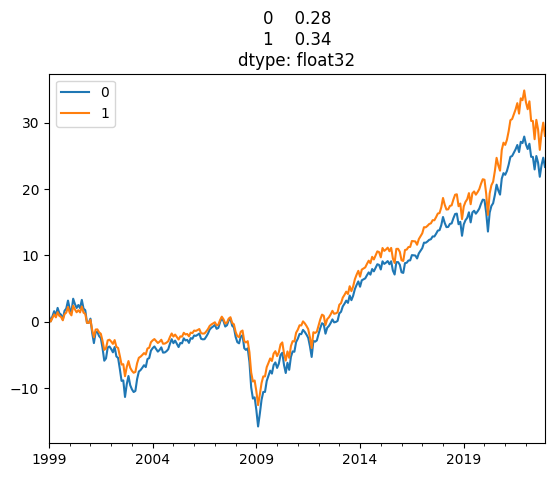

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
timed_returns = test_targets.reshape(-1, 1) * test_predictions.reshape(-1, 1)
together = pd.DataFrame(np.concatenate([test_targets.reshape(-1, 1), timed_returns], axis=1), index=test_dates)
(together / together.std()).cumsum().plot()
plt.title(f'{sharpe_ratio(together)}')

## FINE TUNING

In [37]:
model = models[0]
model.eval()
train_data_predictions, train_data_features = model(X_train_tensor, return_last_hidden=True)
print(train_data_predictions.shape)
print(train_data_features.shape)

test_data_predictions, test_data_features = model(X_test_tensor, return_last_hidden=True)

torch.Size([288, 1])
torch.Size([288, 150])


In [38]:
output_layer = list(model.layers)[-1]  # Get the last layer
# Now, access its weights and biases
weights = output_layer.weight.data
biases = output_layer.bias.data
print("Weights of the output layer:", weights)
print("Biases of the output layer:", biases)

Weights of the output layer: tensor([[ 8.9529e-04, -5.2904e-04, -1.2894e-04,  1.2843e-04,  2.5221e-04,
          2.0122e-02,  5.3754e-04,  1.3897e-04,  2.5244e-04, -1.4575e-04,
          1.2483e-03,  5.5891e-04, -3.3646e-04,  9.4138e-04,  6.2957e-04,
          2.4047e-04,  4.2586e-05, -7.4678e-04,  2.0420e-03,  3.4615e-03,
          4.6152e-04,  1.0174e-03, -3.1949e-03, -1.7555e-05,  1.2434e-02,
          3.4385e-03,  5.6347e-04,  9.7354e-04,  1.9740e-02,  4.1847e-04,
          1.7731e-04, -6.1313e-03, -4.7420e-04,  1.4023e-04,  1.1663e-04,
          1.2553e-02, -3.8661e-04,  1.6563e-04, -4.5659e-04, -1.8121e-04,
          5.9118e-04,  2.5283e-03,  1.9987e-02,  9.9642e-04,  1.5182e-03,
          1.3868e-02, -7.1454e-04,  2.1701e-04, -6.7830e-03, -1.1196e-04,
          2.4606e-04,  1.2679e-02, -3.1343e-04, -9.7399e-03,  2.2414e-02,
         -1.2622e-03,  5.6345e-03,  1.7317e-04, -5.0599e-04, -1.7805e-03,
         -9.0644e-04,  4.7660e-04, -2.6510e-03, -1.1096e-04,  4.4500e-04,
         

In [39]:
new_X_train = torch.concatenate([train_data_features, torch.ones([train_data_features.shape[0], 1])], axis=1)
new_X_test = torch.concatenate([test_data_features, torch.ones([test_data_features.shape[0], 1])], axis=1)

In [40]:
def ridge_regr(signals: np.ndarray,
                  labels: np.ndarray,
                  future_signals: np.ndarray,
                  shrinkage_list: np.ndarray):
    """
    Regression is
    beta = (zI + S'S/t)^{-1}S'y/t = S' (zI+SS'/t)^{-1}y/t
    Inverting matrices is costly, so we use eigenvalue decomposition:
    (zI+A)^{-1} = U (zI+D)^{-1} U' where UDU' = A is eigenvalue decomposition,
    and we use the fact that D @ B = (diag(D) * B) for diagonal D, which saves a lot of compute cost
    :param signals: S
    :param labels: y
    :param future_signals: out of sample y
    :param shrinkage_list: list of ridge parameters
    :return:
    """
    t_ = signals.shape[0]
    p_ = signals.shape[1]
    if p_ < t_:
        # this is standard regression
        eigenvalues, eigenvectors = np.linalg.eigh(signals.T @ signals / t_)
        means = signals.T @ labels.reshape(-1, 1) / t_
        multiplied = eigenvectors.T @ means
        intermed = np.concatenate([(1 / (eigenvalues.reshape(-1, 1) + z)) * multiplied for z in shrinkage_list],
                                  axis=1)
        betas = eigenvectors @ intermed
    else:
        # this is the weird over-parametrized regime
        eigenvalues, eigenvectors = np.linalg.eigh(signals @ signals.T / t_)
        means = labels.reshape(-1, 1) / t_
        multiplied = eigenvectors.T @ means
        intermed = np.concatenate([(1 / (eigenvalues.reshape(-1, 1) + z)) * multiplied for z in shrinkage_list],
                                  axis=1)
        tmp = eigenvectors.T @ signals
        betas = tmp.T @ intermed
    predictions = future_signals @ betas
    return betas, predictions

In [41]:
shrinkage_list = [0.00000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
beta_estimate_using_train_sample, oos_predictions = ridge_regr(signals=new_X_train.detach().numpy(),
                                                                labels=y_train,
                                                                future_signals=new_X_test.detach().numpy(),
                                                                shrinkage_list=shrinkage_list)

In [42]:
test_mse = np.mean((test_targets - test_predictions) ** 2) / np.mean((test_targets) ** 2)
print(f'prediction MSE of the DNN {test_mse}')

prediction MSE of the DNN 1.0075312852859497


In [44]:
fine_tuned_mse = np.mean((test_targets.reshape(-1, 1) - oos_predictions) ** 2, axis=0) / np.mean((test_targets) ** 2)
print(fine_tuned_mse)

array([31.3914597 ,  1.66098458,  1.24079506,  1.03437151,  0.99528939,
        0.99415908,  0.99376554,  0.99831152,  0.99980408,  0.99998008])

# <span style="color:green">CONCLUSION</span>

XXXX